# Multitaper spectral analysis


### Issue

Neural data are non-stationary, while many common time-series analyses assume stationarity. Analyzing short time windows (within which stationarity may hold) provides one solution to this issue, however, this method introduces both bias and variance in the spectral estimation.

### Solution

The multitaper method was designed to address the issues of bias and variance in spectral estimation. This method leverages multiple orthogonol tapers known as discrete prolate spheroidal sequences (dpss) or Slepian sequences. These tapers are designed to optimize the trade-off between narrowband and broadband bias. Furthermore, by averaging mulitple spectral estimates for each time window, the variance of the estimation is reduced. 

### Related Work

The following papers include discussion of this topic:

- [A Review of Multitaper Spectral Analysis](https://pubmed.ncbi.nlm.nih.gov/24759284/), Babadi and Brown, 2014
- [Comparison of spectral analysis methods for characterizing brain oscillations](https://pubmed.ncbi.nlm.nih.gov/17292478/), van Vugt et al., 2007
- [Spectrum Estimation and Harmonic Analysis](https://ieeexplore.ieee.org/document/1456701), Thompson, 1982

### Related Discussion / Examples

The following examples discuss related topics:
-  Mike X Cohen covers multitapers in Chapter 16 of Analyzing Neural Time Series Data: [book](https://direct.mit.edu/books/book/4013/Analyzing-Neural-Time-Series-DataTheory-and), [lecture](https://mikexcohen.com/lecturelets/multitaper/multitaper.html), [associated matlab code](https://github.com/mikexcohen/AnalyzingNeuralTimeSeries/blob/main/chapter16.m), [python translation](https://github.com/lyndond/Analyzing_Neural_Time_Series/blob/master/notebooks/chapter16.ipynb)

In [73]:
# Imports
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from matplotlib.colors import CenteredNorm, TwoSlopeNorm
from neurodsp.utils import create_times, set_random_seed
from mne.time_frequency import tfr_array_multitaper
from scipy.signal.windows import dpss

In [2]:
# Add path and import custom code for the project
import sys
sys.path.append('code')

### Settings

In [3]:
# import seaborn as sns
# sns.set_context('poster')

In [4]:
# Set random seed
set_random_seed(808)

In [5]:
# Set whether to save out figures
SAVE_FIG = False

### Load data and visualize

In [6]:
# load data

# We are setting the sampling frequency here. The data is sampled at 1000 Hz.
fs = 1000 

# Load the channel and the event indices.
fname = "../data/ecog_data.mat"
data_in = loadmat(fname)
sta = data_in['sta'].flatten() # Standard event
tar = data_in['tar'].flatten() # Target event
resp = data_in['resp'].flatten() # Response times
data = data_in['data'].flatten() # Neural data from one ECoG channel
n_seconds = len(data) / fs

# print details
print(f"N seconds: {n_seconds}")
print(f"N standard stimuli: {len(sta)}")
print(f"N target stimuli: {len(tar)}")
print(f"N response times: {len(resp)}")

N seconds: 1459.92
N standard stimuli: 380
N target stimuli: 117
N response times: 117


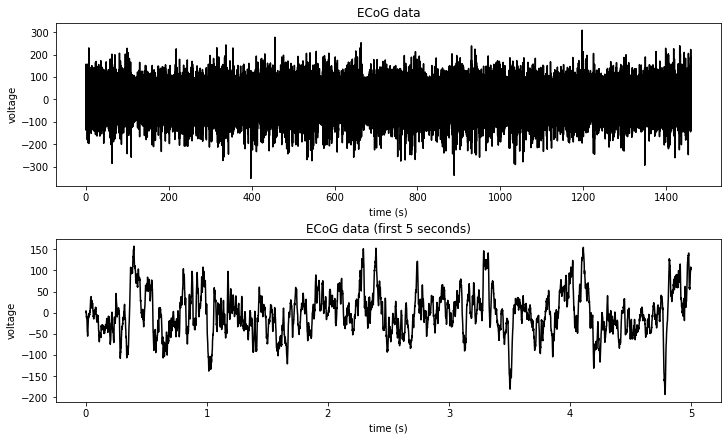

In [7]:
# visulatize time-series

# create time vector
time = create_times(n_seconds, fs)

# plot
fig, (ax1, ax2) = plt.subplots(2,1, figsize=[10,6], constrained_layout=True)
ax1.set_title("ECoG data")
ax1.plot(time, data, color='k') # plot all data
ax2.set_title("ECoG data (first 5 seconds)")
ax2.plot(time[:5*fs], data[:5*fs], color='k') # plot first 5 seconds
for ax in [ax1, ax2]:
    ax.set(xlabel="time (s)", ylabel="voltage")
plt.show()

### Visualize example tapers
Discrete prolate spheroidal sequences (dpss) or Slepian sequences

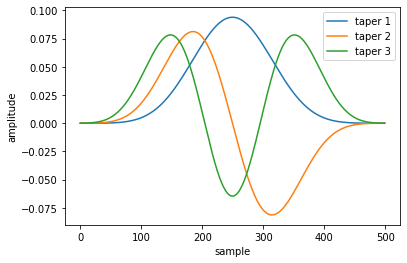

In [99]:
# visualize example tapers

# define parameters
window_length = int(0.5 * fs) # in samples
half_bandwidth = 5 # in Hz
n_tapers = 3 # number of tapers

# compute tapers
tapers = dpss(window_length, half_bandwidth, Kmax=n_tapers)

# plot tapers
fig, ax = plt.subplots(1,1, figsize=[6,4])
for i_taper, taper in enumerate(tapers):
    ax.plot(taper, label=f"taper {i_taper+1}")
ax.set(xlabel="sample", ylabel="amplitude")
ax.legend()

### Compute multitaper - example I
Here we apply the multitaper method to empirical iEEG data. This example leveraged the MNE implementation of the multitaper method [(documentation)](https://mne.tools/stable/generated/mne.time_frequency.tfr_array_multitaper.html).

In [8]:
# apply multitaper method

# reshape data for MNE function
epoch_data = data.reshape(1, 1, -1)

# take first 60 seconds
epoch_data = epoch_data[:, :, :60*fs]
tfr_time = time[:60*fs]

# define frequencies of interst
freq = np.arange(1, 100, 1)

# compute
tfr = tfr_array_multitaper(epoch_data, sfreq=fs, freqs=freq, output='power')
tfr = tfr[0,0] # reshape

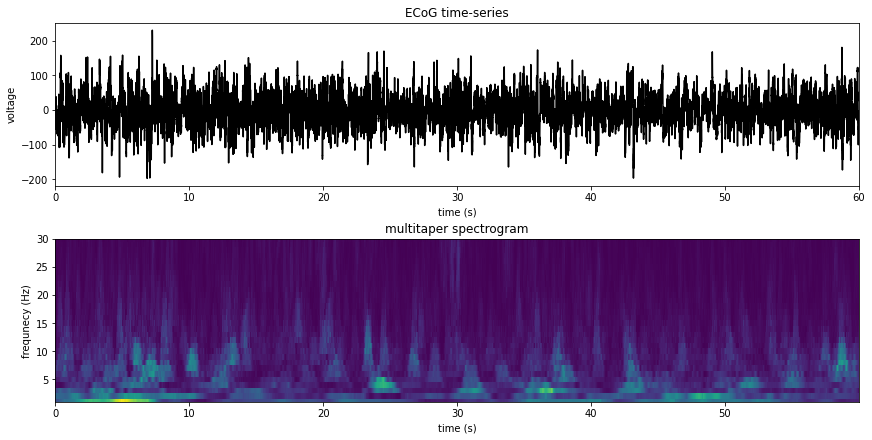

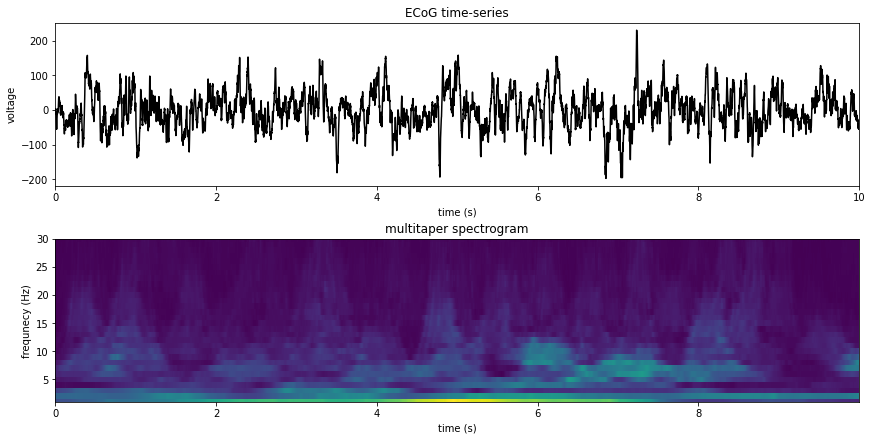

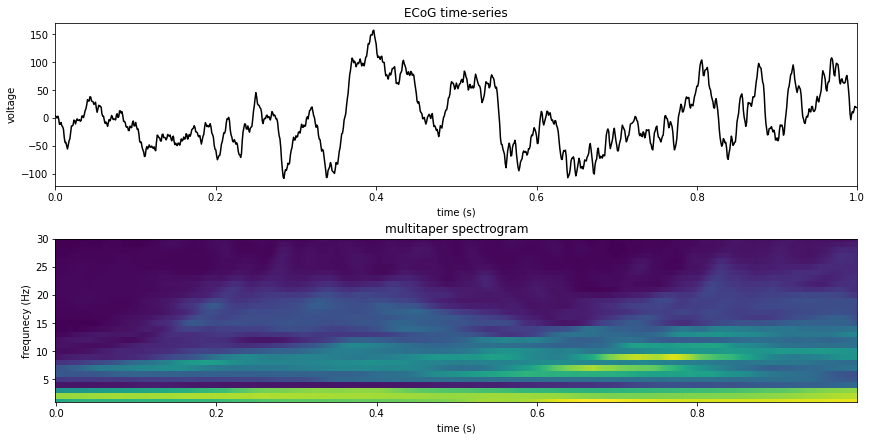

In [9]:
# plot results

for duration in [60, 10, 1]: # plot 60, 10, and 1 seconds of data
    fig, (ax0, ax1) = plt.subplots(2,1, figsize=[12,6], constrained_layout=True)

    # plot time-series
    ax0.plot(tfr_time[:duration*fs], data[:duration*fs], color='k')
    ax0.set(xlabel="time (s)", ylabel="voltage")
    ax0.set_title("ECoG time-series")
    ax0.set_xlim(0, duration)

    # plot spectra
    ax1.pcolormesh(tfr_time[:duration*fs], freq, tfr[:,:duration*fs])
    ax1.set(xlabel="time (s)", ylabel="frequnecy (Hz)")
    ax1.set_title("multitaper spectrogram")
    ax1.set_ylim(1, 30)
    plt.show()

### Compute multitaper - example II (Event-related analysis)
Here we extend our the analysis from example I by computing the average spectral power around a series of events (standard stimuli presentation times).

In [74]:
# helper functions for plotting spectrograms

def zscore_tfr(tfr):
    """
    Normalize time-frequency representation (TFR) by z-scoring each frequency.
    TFR should be 2D (frequency x time).

    Parameters
    ----------
    tfr : 2D array
        Time-frequency representation of power (spectrogram).

    Returns
    -------
    tfr_norm : 2D array
        Z-score normalized TFR.
    """
    
    # initialize 
    tfr_norm = np.zeros(tfr.shape)
    
    # z-score normalize 
    for i_freq in range(tfr.shape[0]):
        tfr_norm[i_freq] = (tfr[i_freq] - np.mean(tfr[i_freq])) / np.std(tfr[i_freq])
        
    return tfr_norm

def subtract_baseline(signals, time, t_baseline):
    """
    Subtract baseline from signals. Baseline is defined as the mean of the
    signal between t_baseline[0] and t_baseline[1]. Signals should be 2D
    (signals x time).

    Parameters
    ----------
    signals : 2D array
        Signals to be baseline corrected.
    time : 1D array
        Time vector.
    t_baseline : 1D array
        Time range for baseline (t_start, t_stop).

    Returns
    -------
    signals_bl : 2D array
        Baseline corrected signals.
    """
    
    # initialize
    signals_bl = np.zeros_like(signals)
    
    # subtract baseline from each signal
    for ii in range(len(signals)):
        mask_bl = ((time>t_baseline[0]) & (time<t_baseline[1]))
        bl = np.mean(signals[ii, mask_bl])
        signals_bl[ii] = signals[ii] - bl
    
    return signals_bl

def crop_tfr(tfr, time, time_range):
    """
    Crop time-frequency representation (TFR) to time_range.
    TFR can be mulitdimensional (time must be last dimension).

    Parameters
    ----------
    tfr : array
        Time-frequency representation of power (spectrogram).
    time : 1D array
        Associated time vector (length should be equal to that of
        the last dimension of tfr).
    time_range : 1D array
        Time range to crop (t_start, t_stop).

    Returns
    -------
    tfr, time : array, array
        Cropped TFR and time vector.
    """
    
    tfr = tfr[..., (time>time_range[0]) & (time<time_range[1])]
    time = time[(time>time_range[0]) & (time<time_range[1])]
    
    return tfr, time


In [81]:
# epoch data around standard stimuli

# initialize array to store epochs
t_window = [-1.25, 1.25] # window around standard stimuli
n_samples = int(np.diff(t_window) * fs) # number of samples in window
n_events = len(sta) # number of events
epoch_data = np.zeros((n_events, n_samples))

# loop through events and eposh data
for i_event, event_index in enumerate(sta):
    epoch_data[i_event] = data[int(event_index + t_window[0]*fs) : int(event_index + t_window[1]*fs)]


In [94]:
# apply multitaper method

# compute
window_length = 0.5
freq_bandwidth = 4
freq = np.arange(2, 100, 1)
n_cycles = freq * window_length # set n_cycles based on fixed time window length
time_bandwidth = int(window_length * freq_bandwidth) # must be >= 2
epoch_data_3d = epoch_data[np.newaxis, :]
tfr = tfr_array_multitaper(epoch_data_3d, sfreq=fs, freqs=freq, n_cycles=n_cycles, 
                        time_bandwidth=time_bandwidth, output='power', n_jobs=-1)
tfr_mean = tfr[0].mean(axis=0) # average across epochs and channels

# crop edge effects
event_time_vector = create_times(n_samples/fs, fs, start_val=t_window[0])
tfr_mean, tfr_time = crop_tfr(tfr_mean, event_time_vector, [t_window[0]+window_length/2, t_window[1]-window_length/2])
print(tfr_mean.shape)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:    5.5s
[Parallel(n_jobs=8)]: Done  96 tasks      | elapsed:    6.9s
[Parallel(n_jobs=8)]: Done 380 out of 380 | elapsed:   11.1s finished


(98, 1999)


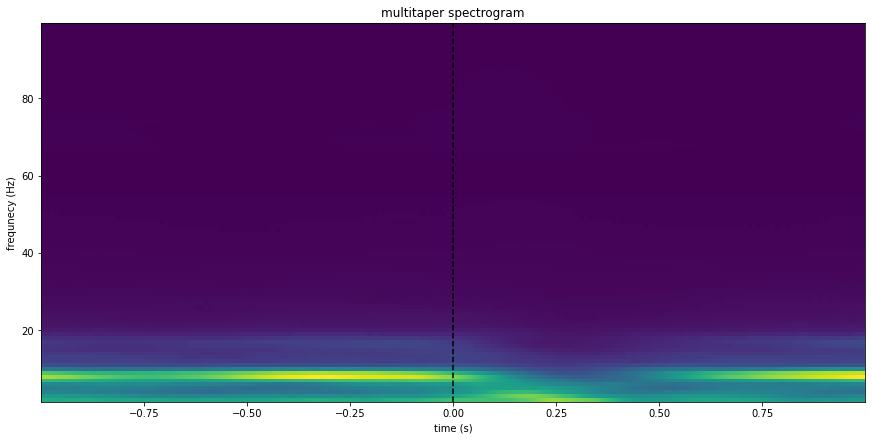

In [96]:
# plot results
fig, ax = plt.subplots(1,1, figsize=[12,6], constrained_layout=True)
ax.pcolormesh(tfr_time, freq, tfr_mean)
ax.set(xlabel="time (s)", ylabel="frequnecy (Hz)")
ax.set_title("multitaper spectrogram")
ax.axvline(0, color='k', linestyle='--')
plt.show()

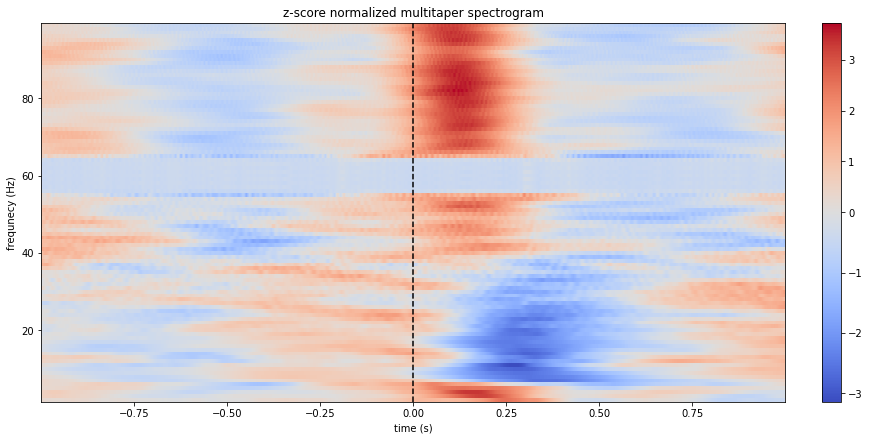

In [98]:
# normalize power at each frequency and subtract baseline power to highlight event-related changes

# normalize
tfr_norm = zscore_tfr(tfr_mean)

# subtract baseline
tfr_norm = subtract_baseline(tfr_norm, tfr_time, [t_window[0], 0])

# plot
fig, ax = plt.subplots(1,1, figsize=[12,6], constrained_layout=True)
ax.pcolormesh(time_plot, freq, tfr_plot, cmap='coolwarm', norm=TwoSlopeNorm(vcenter=0))
ax.set(xlabel="time (s)", ylabel="frequnecy (Hz)")
ax.set_title("z-score normalized multitaper spectrogram")
ax.axvline(0, color='k', linestyle='--')

# add colorbar
cbar = fig.colorbar(ax.pcolormesh(time_plot, freq, tfr_plot, cmap='coolwarm', norm=TwoSlopeNorm(vcenter=0)), ax=ax)
plt.show()

### Compare to other time-resolved spectral estimation techniques (STFT and wavelet)

### Recommendations

### Conclusion

<>